In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

First Lets construct a class to generates input sequences and corresponding target values for multi-horizon forecasting. This is just borrowed from a generic LSTM model

In [2]:
class PowerDataset(Dataset):
    def __init__(self, data, seq_length, n_features, forecast_horizons):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length
        self.n_features = n_features
        self.forecast_horizons = forecast_horizons
        
    def __len__(self):
        return len(self.data) - self.seq_length - max(self.forecast_horizons)
        
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        
        targets = []
        for h in self.forecast_horizons:
            target_idx = idx + self.seq_length + h
            targets.append(self.data[target_idx, 0])  # target/power_x is first column
            
        return x, torch.tensor(targets)

Create an LSTM model using pytorch. I am not familiar with the dataset and have only played with LSTM's once before so I feel keeping the model as simple as possible is best. The below is simply a standard LSTM layer followed by a fully connected linear layer. 

In [3]:
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers, forecast_horizons):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_outputs = len(forecast_horizons)
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 
        )
        
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        
        # Two-layer fully connected with ReLU
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, len(forecast_horizons))
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        # Initialize FC layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        for layer in self.lstm.all_weights:
            for param in layer:
                if len(param.shape) >= 2:
                    nn.init.orthogonal_(param)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        
        x = self.bn(last_time_step)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        predictions = self.fc2(x)
        
        return predictions

A function to create or datasets by first scaling then splitting the data. **I came back here after evaluation and added the train_on_start or train on end functionality to confirm my hypothisis the model will underestimate power output if trained on the end and used to predict the first few months output and overestimate if trained on the begining and used to predict the last few months output.

In [4]:
def create_datasets(df, feature_columns, train_size=0.7, val_size=0.15, train_on_start=True):
    # scale all data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[feature_columns])
    # split into train/val/test
    n = len(scaled_data)
    if train_on_start:  # Train on end of dataset and validate using the beginning
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)
        train_data = scaled_data[:train_end]
        val_data = scaled_data[train_end:val_end]
        test_data = scaled_data[val_end:]
    else:  # Train on start of dataset and validate on end
        test_end = int(n * val_size)
        val_end = test_end + int(n * val_size)
        test_data = scaled_data[:test_end]
        val_data = scaled_data[test_end:val_end]
        train_data = scaled_data[val_end:]
    return scaled_data, train_data, val_data, test_data, scaler

A fairly generice model training loop. If val loss does not improve over 5 (or whatever patience is set to) loops it will trigger an early stop. **Implemented after the first few models I trained quickly learnt to replicate the training data (over fitted)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5, device='mps'):
    model = model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        #print(f'Epoch {epoch+1}/{num_epochs}:')
        #print(f'Training Loss: {train_loss:.4f}')
        #print(f'Validation Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/{name}.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break
    
    return train_losses, val_losses

A function to run the model on an input dataloader and return predictions as well as loss and mse/mae and rmse. Also fairly generice to any LSTM model

In [6]:
def evaluate_model(model, test_loader, criterion, scaler, forecast_horizons, device='mps'):
    model.eval()
    predictions = []
    actuals = []
    test_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
            
            # Inverse transform predictions and actuals
            y_pred_np = y_pred.cpu().numpy()
            y_true_np = y_batch.cpu().numpy()
            
            predictions.append(y_pred_np)
            actuals.append(y_true_np)
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    test_loss = test_loss / len(test_loader)

    target_mean = scaler.mean_[0]   # Mean of power_x (first col)
    target_std = scaler.scale_[0]   # Standard deviation power_x (first col)
    
    # Inverse transform our predictions and actual values
    predictions = (predictions * target_std) + target_mean
    actuals = (actuals * target_std) + target_mean
    
    # Calculate metrics for each forecast horizon
    metrics = {}
    for i, horizon in enumerate(forecast_horizons):
        horizon_preds = predictions[:, i]
        horizon_actuals = actuals[:, i]
        
        mse = np.mean((horizon_preds - horizon_actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(horizon_preds - horizon_actuals))
        
        metrics[f'{horizon}h_ahead'] = {
            'MAE': mae,
            'RMSE': rmse
        }
    
    return metrics, test_loss, predictions, actuals

Load our cleaned and feature engineered dataset

In [7]:
df = pd.read_csv('data/forecast_data_cleaned_feature_engineered.csv')
df['date'] = pd.to_datetime(df['date']) 
df.set_index('date', inplace=True)

target = 'power_x' # make target the first col for convenience
column = df[target]
df = df.drop(columns=[target])
df.insert(0, target, column)
features = list(df)

Configure and initialise our model

Fetch our datasets / loaders. We will be testing and validating using the beginning of the dataset not the ends. See `01_Exploratory_Data_Analysis.ipynb` for motivation. But in short this way all datasets have a more similiar distribution and we avoid trying to forecast out of distribution scenarios. 

In [8]:
model_name = 'best_model'
full_data , train_data, val_data, test_data, scaler = create_datasets(df, features, train_on_start = False) 

In [9]:
seq_length = 24  # 24 hours of history, bit unsure whats best. this will at least get the full diurnal cycle 
forecast_horizons = [1, 2, 3, 4, 5, 6]  # Hours ahead to predict
n_features = len(features)
batch_size = 480 # on my 16gb RAM M4 Mac Mini

full_dataset = PowerDataset(full_data, seq_length, n_features, forecast_horizons)
train_dataset = PowerDataset(train_data, seq_length, n_features, forecast_horizons)
val_dataset = PowerDataset(val_data, seq_length, n_features, forecast_horizons)
test_dataset = PowerDataset(test_data, seq_length, n_features, forecast_horizons)

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
# fixed model params
learning_rate = 3e-4 # idk https://x.com/karpathy/status/801621764144971776?lang=en&mx=2
num_epochs = 100 # most likely reach early stop before anyway
criterion = nn.L1Loss() # aka MAE should be better than RMSE on peaky data I believe

a quick hyper parameter optimisation:

In [11]:
best_params = {}
best_val_loss = float('inf')

hidden_sizes = [16, 32, 64, 128, 256]
layer_counts = [1, 2, 3]

for hidden_size in hidden_sizes:
    for num_layers in layer_counts:
        model = LSTMForecaster(
            n_features=n_features, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            forecast_horizons=forecast_horizons
        )
        
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=1e-5
        )
        
        train_losses, val_losses = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=nn.L1Loss(),
            optimizer=optimizer,
            num_epochs=num_epochs,
            name = model_name,
            patience=10
        )
        
        final_val_loss = val_losses[-1]
        
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers
            }

/Users/petermarsh/.local/share/mamba/envs/pytorch_downscaling/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Early stopping triggered


/Users/petermarsh/.local/share/mamba/envs/pytorch_downscaling/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered


In [12]:
best_params # {'hidden_size': 128, 'num_layers': 1} for train on start

{'hidden_size': 64, 'num_layers': 1}

Run again with the best params

In [13]:
model = LSTMForecaster(
    n_features=n_features, 
    hidden_size=best_params['hidden_size'], 
    num_layers=best_params['num_layers'], 
    forecast_horizons=forecast_horizons
)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5
)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.L1Loss(),
    optimizer=optimizer,
    num_epochs=num_epochs,
    name = model_name,
    patience=10
)


Early stopping triggered


Train vs Val loss plot:

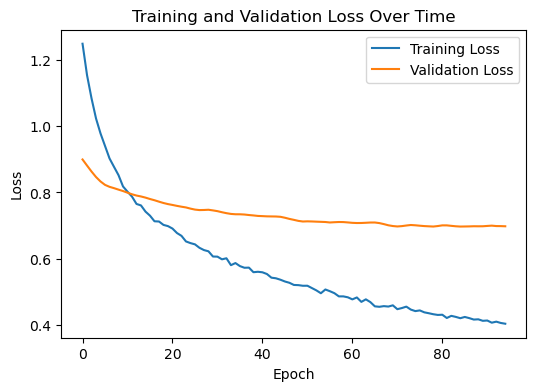

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

eval on test and val data and print outputs

In [15]:
# test set
metrics, test_loss, predictions, actuals = evaluate_model(
    model, test_loader, criterion, scaler, forecast_horizons
)

# include val set to check for overfitting
val_metrics, val_loss, val_predictions, val_actuals = evaluate_model(
    model, val_loader, criterion, scaler, forecast_horizons
)

for horizon, metric in metrics.items():
    print(f"\n{horizon:<20}{'Test':>10}    {'Validation':>10}")  

    for name in metrics[horizon]:  # Iterate through metric names
        test_value = metrics[horizon][name]
        val_value = val_metrics[horizon][name]
        print(f"{name:<20}{test_value:>10.4f}{val_value:>10.4f}")

    print("-" * 50)

# Optionally print losses side-by-side
print("\nLosses:")
print(f"{'Set':<10}{'Loss':>10}")
print("-" * 20)
print(f"{'Test':<10}{test_loss:>10.4f}")
print(f"{'Validation':<10}{val_loss:>10.4f}")
print("-" * 20)


1h_ahead                  Test    Validation
MAE                  1184.1011 1227.1032
RMSE                 1461.6427 1566.9375
--------------------------------------------------

2h_ahead                  Test    Validation
MAE                  1086.9703 1368.4622
RMSE                 1400.8762 1726.7657
--------------------------------------------------

3h_ahead                  Test    Validation
MAE                  1130.5233 1308.1286
RMSE                 1400.3162 1649.5672
--------------------------------------------------

4h_ahead                  Test    Validation
MAE                  1244.4947 1337.3612
RMSE                 1540.2198 1692.1273
--------------------------------------------------

5h_ahead                  Test    Validation
MAE                  1211.8895 1250.0002
RMSE                 1497.9091 1690.0856
--------------------------------------------------

6h_ahead                  Test    Validation
MAE                  1244.4363 1287.1951
RMSE              

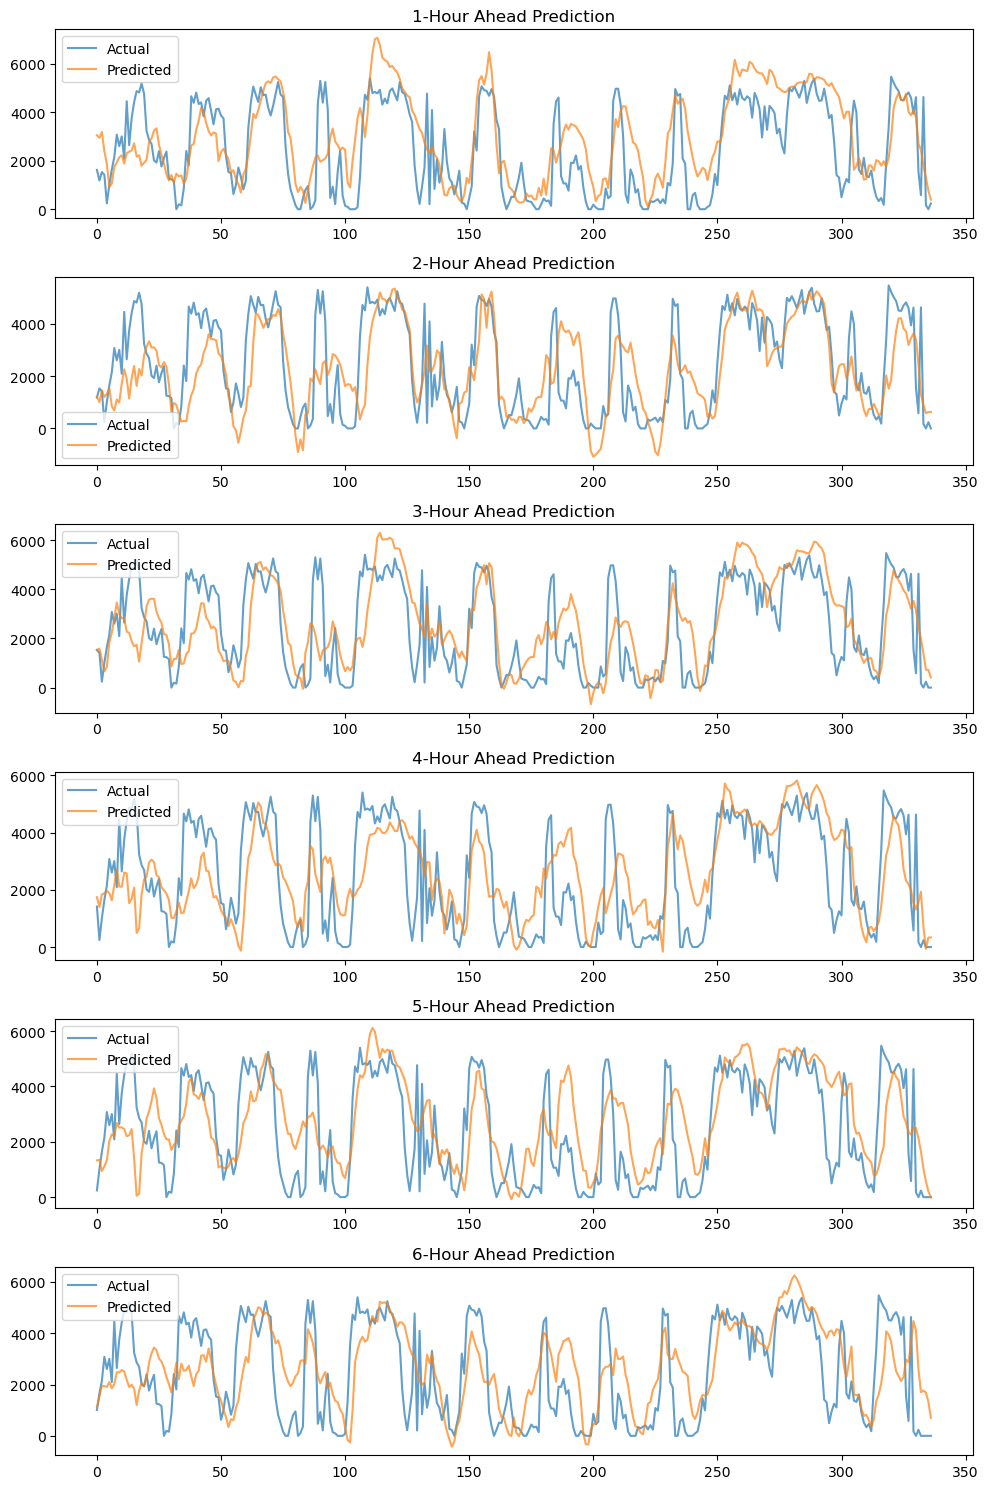

In [16]:
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

for i, horizon in enumerate(forecast_horizons):
    ax = axes[i] if 6 > 1 else axes
    ax.plot(actuals[:, i], label='Actual', alpha=0.7)
    ax.plot(predictions[:, i], label='Predicted', alpha=0.7)
    ax.set_title(f'{horizon}-Hour Ahead Prediction')
    ax.legend()

plt.tight_layout()
plt.show()

Make Prediction over full range and save to csv for later analysis

In [17]:
metrics, test_loss, predictions, actuals = evaluate_model(
    model, full_loader, criterion, scaler, forecast_horizons
)

In [18]:
df = pd.read_csv('data/forecast_data_cleaned_feature_engineered.csv')
df['date'] = pd.to_datetime(df['date']) 
df.set_index('date', inplace=True)

target = 'power_x' # make target the first col for convenience
column = df[target]
df = df.drop(columns=[target])
df.insert(0, target, column)
df = df[24:-6]
df[[f'pred_{x}h' for x in forecast_horizons]] = predictions
df[[f'act_{x}h' for x in forecast_horizons]] = actuals

In [19]:
df.to_csv(f'data/forecast_data_cleaned_feature_engineered_with_prediction_{model_name}.csv')